# Installation Setup

In [126]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [127]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
from scipy import stats
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns; sns.set()
from pandas.tseries.offsets import *
from dateutil.relativedelta import *
import datetime as dt
import os
from linearmodels.asset_pricing import TradedFactorModel, LinearFactorModel
from IPython.core.pylabtools import figsize
from IPython.core.interactiveshell import InteractiveShell
from fredapi import Fred
fred = Fred(api_key = 'b0363f9c9d853b92b27e06c4727bc2ea')
import pandas_datareader.data as web

%matplotlib inline 
%pylab inline
pylab.rcParams['figure.figsize'] = (10,5)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [128]:
import pickle
from multiprocessing import Pool 
import random
import json
import sys
import torch
import gym

import StockPortfolioEnv
import utils
import TD3_BC

import pytz
import itertools
from datetime import datetime as dt
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from finrl import config
from finrl import config_tickers
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [129]:
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('mode.use_inf_as_na', True)
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 500)
idx = pd.IndexSlice
import warnings
warnings.filterwarnings('ignore')

# Environment configuration
> A gym-style portfolio allocation environment for agents to interact. It is handy to compare the performances.

In [130]:
train_data = pd.read_csv('data/train_data.csv', index_col=0)
trade_data = pd.read_csv('data/trade_data.csv', index_col=0)

In [131]:
train_data

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,fake_macd,fake_rsi_30,fake_cci_30,fake_dx_30,moribvol,equal
0,2007-01-03,16.630,17.250,16.620,8.712,5540800,CNP,2,0.000,8.741,8.698,100.000,66.667,100.000,8.712,8.712,0.553,184.415,37.747,50.888,0.061,0.091
0,2007-01-03,66.030,66.250,64.240,44.847,6297900,DVN,2,0.000,8.741,8.698,100.000,66.667,100.000,44.847,44.847,1.422,161.244,-71.950,43.568,0.091,0.091
0,2007-01-03,18.250,18.790,18.200,8.567,282800,FNB,2,0.000,8.741,8.698,100.000,66.667,100.000,8.567,8.567,1.869,9.479,273.147,0.828,0.015,0.091
0,2007-01-03,12.230,12.350,12.080,8.387,3313000,IPG,2,0.000,8.741,8.698,100.000,66.667,100.000,8.387,8.387,-0.613,-75.941,146.436,0.761,0.045,0.091
0,2007-01-03,21.530,21.890,21.160,17.301,565300,JKHY,2,0.000,8.741,8.698,100.000,66.667,100.000,17.301,17.301,1.920,48.334,110.275,11.797,0.167,0.091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2768,2017-12-29,35.890,35.890,35.400,32.854,133500,MLI,4,0.210,33.772,32.589,54.130,8.048,3.167,32.893,32.347,1.520,116.910,-182.644,-4.377,0.015,0.091
2768,2017-12-29,49.490,49.760,49.280,45.486,1340300,SEE,4,0.797,46.025,43.477,63.352,103.275,34.896,43.983,42.412,0.444,44.696,128.476,-14.028,0.076,0.091
2768,2017-12-29,32.341,32.607,32.119,30.584,102872,TR,4,0.039,31.573,30.107,49.152,-49.226,3.944,30.805,30.547,-0.699,50.530,-99.285,45.962,0.152,0.091
2768,2017-12-29,150.450,151.660,149.750,149.860,881900,VRTX,4,1.359,153.807,135.300,52.986,117.528,21.640,145.122,147.850,0.083,-113.917,103.017,3.120,0.106,0.091


In [132]:
# Environment arguments 
stock_dimension = len(train_data.tic.unique())
state_space = stock_dimension
tech_indicator_list = ['macd', 'rsi_30', 'cci_30', 'dx_30']
fake_tech_indicator_list = ['fake_macd', 'fake_rsi_30', 'fake_cci_30', 'fake_dx_30']
feature_dimension = len(tech_indicator_list)

print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")
print(f"Feature Dimension: {feature_dimension}")

env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": tech_indicator_list, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-1
}

e_train_gym = StockPortfolioEnv.StockPortfolioEnv(df = train_data, **env_kwargs)
e_trade_gym = StockPortfolioEnv.StockPortfolioEnv(df = trade_data, **env_kwargs)

Stock Dimension: 11, State Space: 11
Feature Dimension: 4


In [133]:
# Train
retail_train = StockPortfolioEnv.sample_from_env(i=0, env=e_train_gym, weights=train_data["moribvol"])
true_portfolio_train = e_train_gym.asset_memory
true_actions_train = e_train_gym.actions_memory

# Trade
_ = StockPortfolioEnv.sample_from_env(i=0, env=e_trade_gym, weights=trade_data["moribvol"])
true_portfolio_trade = e_trade_gym.asset_memory
true_actions_trade = e_trade_gym.actions_memory

begin_total_asset:1000000
end_total_asset:6403042.609186866
Sharpe:  0.8026856203880117
begin_total_asset:1000000
end_total_asset:2435767.249356905
Sharpe:  1.0055874605495567


# Modelling
> Use a two-stage scheme (supervised learning & reinforcement learning), in analogy to AlphaGo and ChatGPT. The first stage learns from human trader logs, while the second stage leverages reinforcement learning to achieve super-human performance.

In [134]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [135]:
# helper functions
def softmax(x):
    """Compute softmax values for each row of x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=1, keepdims=True)

def plot_portfolio(y1, y2):
    plt.plot(y1, label='model')
    plt.plot(y2, label='Ground Truth')
    plt.scatter(len(y1)-1, y1[-1], color='blue', label='Model last value: {}'.format(y1[-1]))
    plt.scatter(len(y2)-1, y2[-1], color='red', label='Ground Truth last value: {}'.format(y2[-1]))

    plt.legend()
    plt.ylabel('Portfolio Value')
    plt.xlabel('timesteps')
    plt.show()
    
def plot_mse(y1, y2):
    plt.plot(np.mean((y1 - y2.values.reshape(-1, stock_dimension)), axis=1)**2)
    plt.ylabel('MSE')
    plt.xlabel('timesteps')
    plt.show()
    
def ols_return(y1, y2):
    olsres = sm.OLS(pd.Series(y1).pct_change(), sm.add_constant(pd.Series(y2).pct_change()), missing="drop").fit()
    print(olsres.summary())
    
def ols_action(a1, a2):
    olsres = sm.OLS(a1.values, sm.add_constant(a2.reshape(-1))).fit()
    print(olsres.summary())
    
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, scale_data=True):
        if not torch.is_tensor(X) and not torch.is_tensor(y):
            # Apply scaling if necessary
            if scale_data:
                X = StandardScaler(with_mean=True, with_std=True).fit_transform(X)
            self.X = torch.from_numpy(X)
            self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [136]:
X = train_data[tech_indicator_list]
Y = train_data["moribvol"]

X_trade = trade_data[tech_indicator_list]
Y_trade = trade_data["moribvol"]

X_fake_train = train_data[fake_tech_indicator_list]
X_fake_trade = trade_data[fake_tech_indicator_list]

## Regression

In [137]:
olsres = sm.OLS(Y.values.reshape(-1), sm.add_constant(X.values.reshape(-1, feature_dimension))).fit()

# train
reg_fit = olsres.predict(sm.add_constant(X.values.reshape(-1, feature_dimension))).reshape(-1, stock_dimension)
reg_fit = softmax(reg_fit)

# trade
reg_trade = olsres.predict(sm.add_constant(X_trade.values.reshape(-1, feature_dimension))).reshape(-1, stock_dimension)
reg_trade = softmax(reg_trade)

begin_total_asset:1000000
end_total_asset:2834879.829353712
Sharpe:  0.5085675601172683


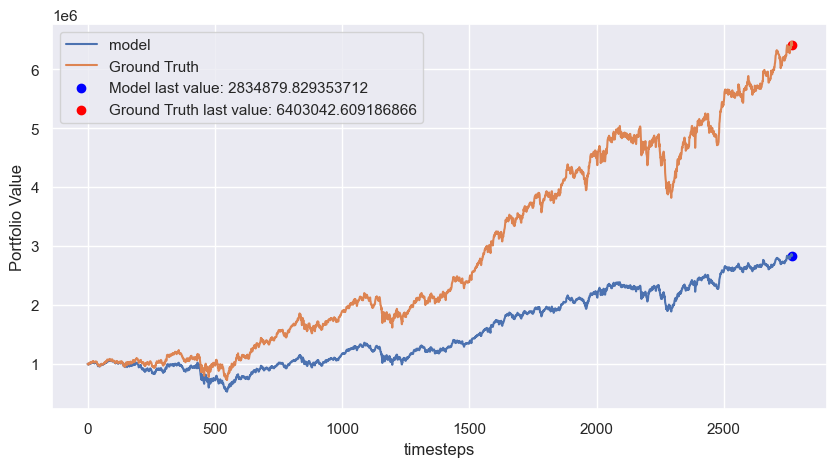

begin_total_asset:1000000
end_total_asset:1797618.2985341903
Sharpe:  0.7071632332582373


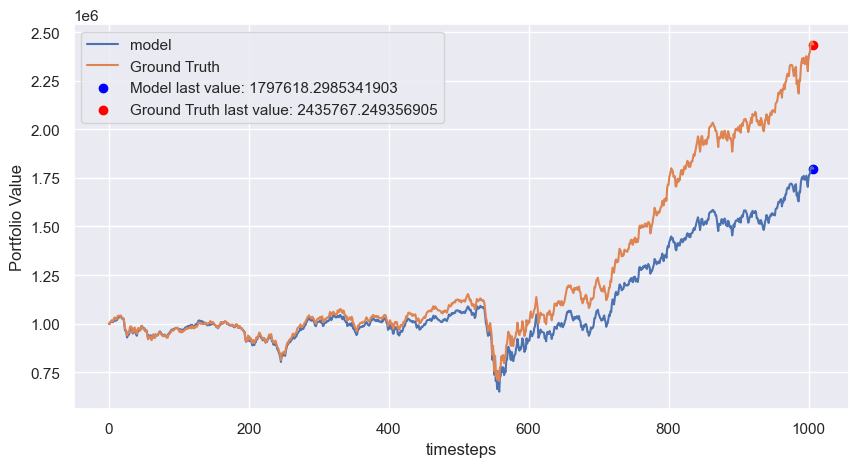

In [138]:
# train
_ = StockPortfolioEnv.sample_from_env(i=0, env=e_train_gym, weights=reg_fit)
reg_portfolio_train = e_train_gym.asset_memory
plot_portfolio(reg_portfolio_train, true_portfolio_train)

# trade
_ = StockPortfolioEnv.sample_from_env(i=0, env=e_trade_gym, weights=reg_trade)
reg_portfolio_trade = e_trade_gym.asset_memory
plot_portfolio(reg_portfolio_trade, true_portfolio_trade)

In [139]:
ols_return(true_portfolio_train, reg_portfolio_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                 8.782e+04
Date:                Thu, 06 Apr 2023   Prob (F-statistic):               0.00
Time:                        05:07:26   Log-Likelihood:                 12400.
No. Observations:                2768   AIC:                        -2.480e+04
Df Residuals:                    2766   BIC:                        -2.478e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003   5.22e-05      5.724      0.0

In [140]:
ols_return(true_portfolio_trade, reg_portfolio_trade)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                 3.014e+04
Date:                Thu, 06 Apr 2023   Prob (F-statistic):               0.00
Time:                        05:07:27   Log-Likelihood:                 4465.9
No. Observations:                1007   AIC:                            -8928.
Df Residuals:                    1005   BIC:                            -8918.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003   9.06e-05      3.446      0.0

In [141]:
ols_action(train_data["moribvol"], reg_fit)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     78.74
Date:                Thu, 06 Apr 2023   Prob (F-statistic):           7.47e-19
Time:                        05:07:27   Log-Likelihood:                 49366.
No. Observations:               30459   AIC:                        -9.873e+04
Df Residuals:                   30457   BIC:                        -9.871e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4519      0.174     -8.351      0.0

In [142]:
ols_action(trade_data["moribvol"], reg_trade)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     10.40
Date:                Thu, 06 Apr 2023   Prob (F-statistic):            0.00127
Time:                        05:07:27   Log-Likelihood:                 17967.
No. Observations:               11088   AIC:                        -3.593e+04
Df Residuals:                   11086   BIC:                        -3.592e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8465      0.291     -2.912      0.0

## RandomForest

In [143]:
clf = RandomForestRegressor(max_depth=2, random_state=0)
clf.fit(X, Y)

# train
clf_fit = clf.predict((X.values.reshape(-1, feature_dimension))).reshape(-1, stock_dimension)
clf_fit = softmax(clf_fit)

# trade
clf_trade = clf.predict((X_trade.values.reshape(-1, feature_dimension))).reshape(-1, stock_dimension)
clf_trade = softmax(clf_trade)

RandomForestRegressor(max_depth=2, random_state=0)

begin_total_asset:1000000
end_total_asset:2832082.918173314
Sharpe:  0.5081802184264346


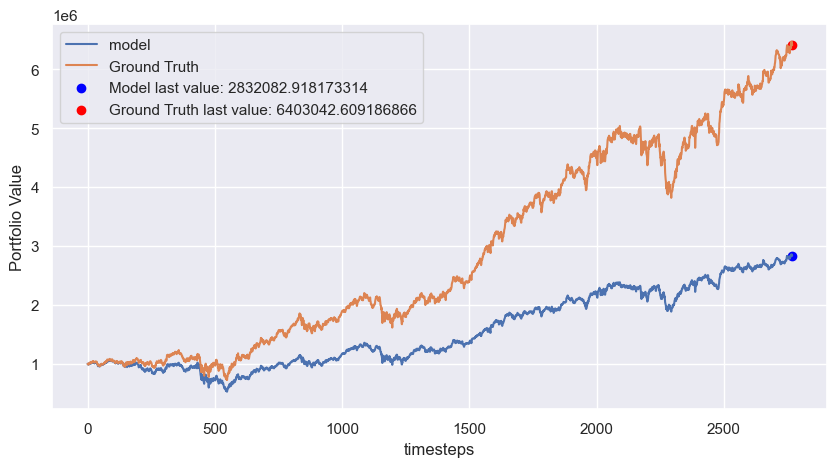

begin_total_asset:1000000
end_total_asset:1797247.777131589
Sharpe:  0.70693030228864


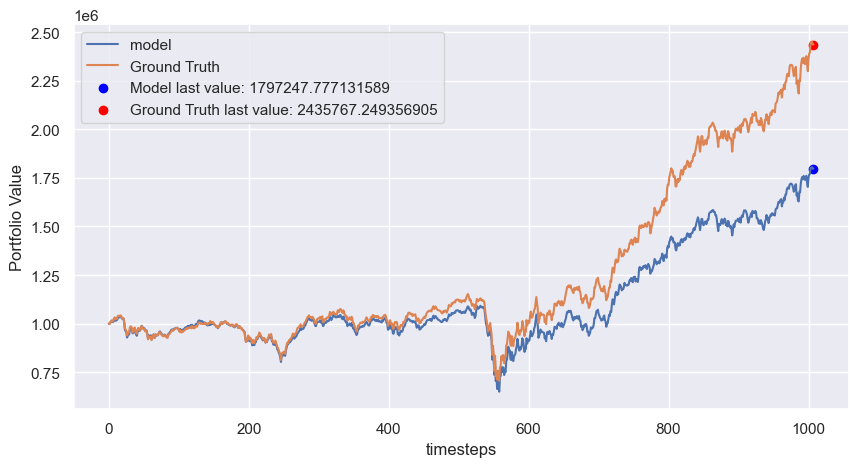

In [144]:
# train
_ = StockPortfolioEnv.sample_from_env(i=0, env=e_train_gym, weights=clf_fit)
clf_portfolio_train = e_train_gym.asset_memory
plot_portfolio(clf_portfolio_train, true_portfolio_train)

# trade
_ = StockPortfolioEnv.sample_from_env(i=0, env=e_trade_gym, weights=clf_trade)
clf_portfolio_trade = e_trade_gym.asset_memory
plot_portfolio(clf_portfolio_trade, true_portfolio_trade)

In [145]:
ols_return(true_portfolio_train, clf_portfolio_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                 8.776e+04
Date:                Thu, 06 Apr 2023   Prob (F-statistic):               0.00
Time:                        05:07:36   Log-Likelihood:                 12399.
No. Observations:                2768   AIC:                        -2.479e+04
Df Residuals:                    2766   BIC:                        -2.478e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003   5.22e-05      5.729      0.0

In [146]:
ols_return(true_portfolio_trade, clf_portfolio_trade)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                 3.013e+04
Date:                Thu, 06 Apr 2023   Prob (F-statistic):               0.00
Time:                        05:07:37   Log-Likelihood:                 4465.7
No. Observations:                1007   AIC:                            -8927.
Df Residuals:                    1005   BIC:                            -8918.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003   9.06e-05      3.448      0.0

## LSTM

In [147]:
# Set seeds
seed = 0
e_train_gym.seed(seed)
e_train_gym.action_space.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

# Prepare dataset
X = X.astype(np.float32) 
Y = Y.astype(np.float32) 
X_trade = X_trade.astype(np.float32) 
Y_trade = Y_trade.astype(np.float32)

train_dataset = Dataset(X.values.reshape(-1, stock_dimension*feature_dimension), Y.values.reshape(-1, stock_dimension))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
trade_dataset = Dataset(X_trade.values.reshape(-1, stock_dimension*feature_dimension), Y_trade.values.reshape(-1, stock_dimension))

[0]

In [148]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return F.softmax(out)

In [149]:
lstm = LSTMModel(input_size=stock_dimension*feature_dimension, 
                 hidden_size=128, 
                 num_layers=1, 
                 output_size=stock_dimension)

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=3e-4)
num_epochs = 10000

# Train the model
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = lstm(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

begin_total_asset:1000000
end_total_asset:5559128.10261967
Sharpe:  0.7512070187878667


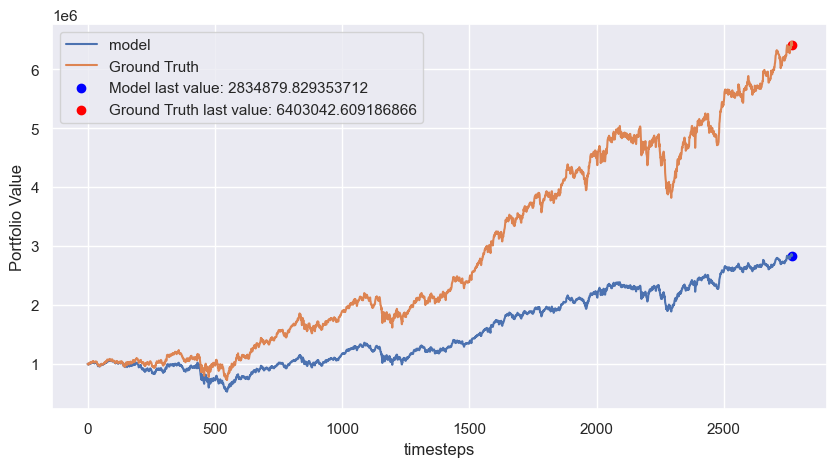

begin_total_asset:1000000
end_total_asset:2210004.7210114044
Sharpe:  0.8363297634276766


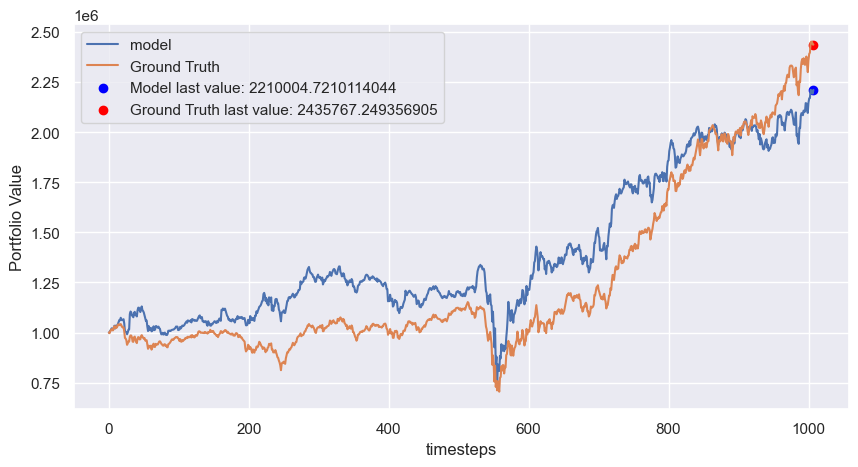

In [150]:
# train
lstm_fit = lstm(train_dataset.X).detach().numpy()
_ = StockPortfolioEnv.sample_from_env(i=0, env=e_train_gym, weights=lstm_fit)
lstm_portfolio_train = e_train_gym.asset_memory
plot_portfolio(reg_portfolio_train, true_portfolio_train)

# trade
lstm_trade = lstm(trade_dataset.X).detach().numpy()
_ = StockPortfolioEnv.sample_from_env(i=0, env=e_trade_gym, weights=lstm_trade)
lstm_portfolio_trade = e_trade_gym.asset_memory
plot_portfolio(lstm_portfolio_trade, true_portfolio_trade)

In [151]:
ols_return(true_portfolio_train, lstm_portfolio_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 5.908e+05
Date:                Thu, 06 Apr 2023   Prob (F-statistic):               0.00
Time:                        08:56:28   Log-Likelihood:                 15002.
No. Observations:                2768   AIC:                        -3.000e+04
Df Residuals:                    2766   BIC:                        -2.999e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.266e-05   2.04e-05      2.581      0.0

In [152]:
ols_return(true_portfolio_trade, lstm_portfolio_trade)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     2714.
Date:                Thu, 06 Apr 2023   Prob (F-statistic):          8.61e-288
Time:                        08:56:28   Log-Likelihood:                 3395.8
No. Observations:                1007   AIC:                            -6788.
Df Residuals:                    1005   BIC:                            -6778.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.118      0.2

## Neural Net

In [153]:
class NeuralNet(nn.Module):
	def __init__(self, state_dim, action_dim, max_action):
		super(NeuralNet, self).__init__()
		self.l1 = nn.Linear(state_dim, 128)
		self.l2 = nn.Linear(128, 128)
		self.l3 = nn.Linear(128, action_dim)
		self.max_action = max_action

	def forward(self, state):
		a = F.relu(self.l1(state))
		a = F.relu(self.l2(a))
		return self.max_action * F.softmax(self.l3(a))

In [154]:
ann = NeuralNet(state_dim=stock_dimension*feature_dimension, 
                action_dim=stock_dimension, 
                max_action=float(e_train_gym.action_space.high[0]))

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(ann.parameters(), lr=3e-4)
num_epochs = 10000

# Train the model
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = ann(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

begin_total_asset:1000000
end_total_asset:6279397.231883736
Sharpe:  0.797904427137939


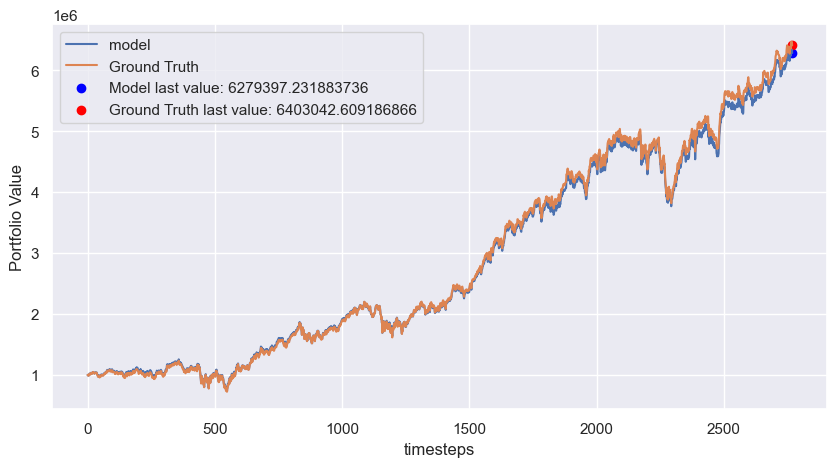

begin_total_asset:1000000
end_total_asset:2737270.184906772
Sharpe:  1.117408966326219


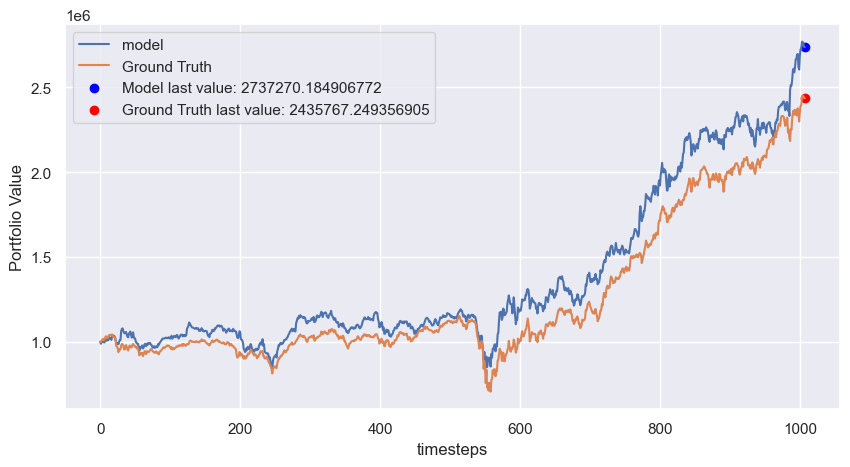

In [176]:
# train
ann_fit = ann(train_dataset.X).detach().numpy()
_ = StockPortfolioEnv.sample_from_env(i=0, env=e_train_gym, weights=ann_fit)
ann_portfolio_train = e_train_gym.asset_memory
plot_portfolio(ann_portfolio_train, true_portfolio_train)

# trade 
ann_trade = ann(trade_dataset.X).detach().numpy()
_ = StockPortfolioEnv.sample_from_env(i=0, env=e_trade_gym, weights=ann_trade)
ann_portfolio_trade = e_trade_gym.asset_memory
plot_portfolio(ann_portfolio_trade, true_portfolio_trade)

In [156]:
ols_return(true_portfolio_train, ann_portfolio_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 9.414e+05
Date:                Thu, 06 Apr 2023   Prob (F-statistic):               0.00
Time:                        09:09:44   Log-Likelihood:                 15644.
No. Observations:                2768   AIC:                        -3.128e+04
Df Residuals:                    2766   BIC:                        -3.127e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.273e-05   1.62e-05      0.787      0.4

In [157]:
ols_return(true_portfolio_trade, ann_portfolio_trade)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     2219.
Date:                Thu, 06 Apr 2023   Prob (F-statistic):          1.35e-256
Time:                        09:09:44   Log-Likelihood:                 3323.8
No. Observations:                1007   AIC:                            -6644.
Df Residuals:                    1005   BIC:                            -6634.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      2.941      0.0

### Placebo Test

In [158]:
X_fake_train = X_fake_train.astype(np.float32) 
X_fake_trade = X_fake_trade.astype(np.float32) 

fake_train_dataset = Dataset(X_fake_train.values.reshape(-1, stock_dimension*feature_dimension), Y.values.reshape(-1, stock_dimension))
fake_train_dataloader = torch.utils.data.DataLoader(fake_train_dataset, batch_size=256, shuffle=True)
fake_trade_dataset = Dataset(X_fake_trade.values.reshape(-1, stock_dimension*feature_dimension), Y_trade.values.reshape(-1, stock_dimension))

In [159]:
ann = NeuralNet(state_dim=stock_dimension*feature_dimension, 
                action_dim=stock_dimension, 
                max_action=float(e_train_gym.action_space.high[0]))

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(ann.parameters(), lr=3e-4)
num_epochs = 10000

# Train the model
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = ann(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()

begin_total_asset:1000000
end_total_asset:2694079.102704435
Sharpe:  0.44726985146649284


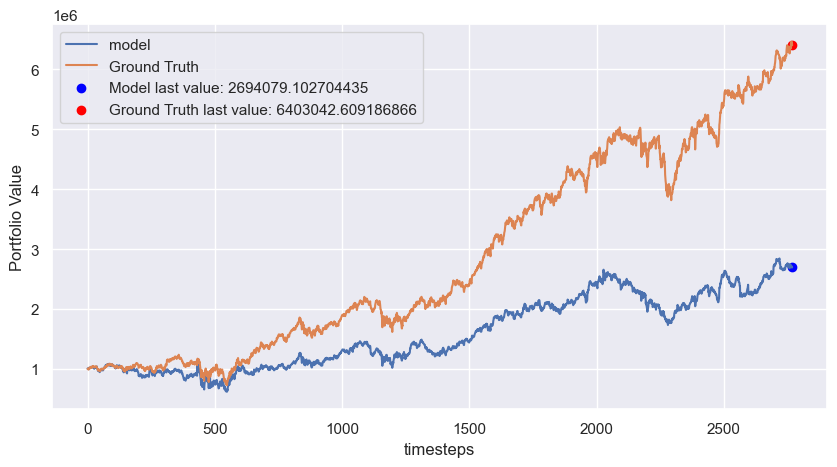

begin_total_asset:1000000
end_total_asset:1540849.0972664012
Sharpe:  0.5153168351008476


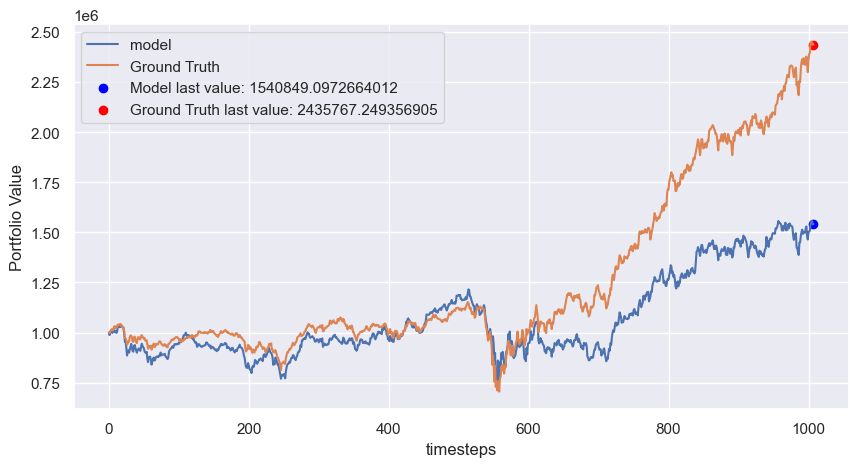

In [160]:
# train
fake_ann_fit = ann(fake_train_dataset.X).detach().numpy()
_ = StockPortfolioEnv.sample_from_env(i=0, env=e_train_gym, weights=fake_ann_fit)
fake_ann_portfolio_train = e_train_gym.asset_memory
plot_portfolio(fake_ann_portfolio_train, true_portfolio_train)

# trade 
fake_ann_trade = ann(fake_trade_dataset.X).detach().numpy()
_ = StockPortfolioEnv.sample_from_env(i=0, env=e_trade_gym, weights=fake_ann_trade)
fake_ann_portfolio_trade = e_trade_gym.asset_memory
plot_portfolio(fake_ann_portfolio_trade, true_portfolio_trade)

In [161]:
ols_return(true_portfolio_train, fake_ann_portfolio_train)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     6256.
Date:                Thu, 06 Apr 2023   Prob (F-statistic):               0.00
Time:                        09:22:59   Log-Likelihood:                 9207.7
No. Observations:                2768   AIC:                        -1.841e+04
Df Residuals:                    2766   BIC:                        -1.840e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      2.574      0.0

In [162]:
ols_return(true_portfolio_trade, fake_ann_portfolio_trade)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     1884.
Date:                Thu, 06 Apr 2023   Prob (F-statistic):          1.11e-232
Time:                        09:22:59   Log-Likelihood:                 3268.7
No. Observations:                1007   AIC:                            -6533.
Df Residuals:                    1005   BIC:                            -6524.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      1.997      0.0

# In a Nutshell

In [163]:
def backtest_helper(ret, data):
    df = pd.DataFrame(ret, columns=['account_value'])
    df['date'] = data['date'].unique()
    perf_stats_all = backtest_stats(df)

Text(0.5, 0, 'Timesteps')

Text(0.5, 1.0, 'Train')

Text(0, 0.5, 'Portfolio Value')

Text(0.5, 0, 'Timesteps')

Text(0.5, 1.0, 'Trade')

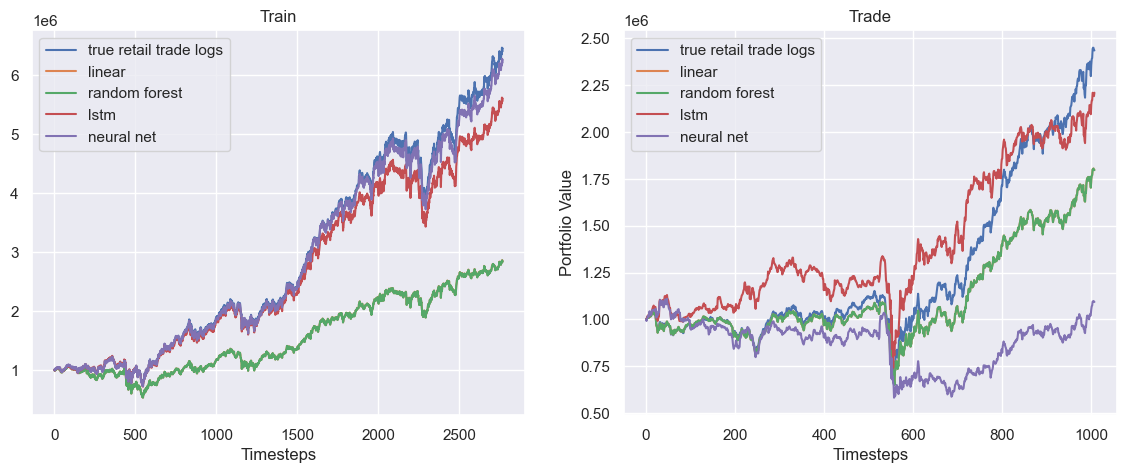

In [164]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(true_portfolio_train, label='true retail trade logs')
axs[0].plot(reg_portfolio_train, label='linear')
axs[0].plot(clf_portfolio_train, label='random forest')
axs[0].plot(lstm_portfolio_train, label='lstm')
axs[0].plot(ann_portfolio_train, label='neural net')
axs[0].set_xlabel('Timesteps')
axs[0].set_title('Train')
axs[0].legend()

axs[1].plot(true_portfolio_trade, label='true retail trade logs')
axs[1].plot(reg_portfolio_trade, label='linear')
axs[1].plot(clf_portfolio_trade, label='random forest')
axs[1].plot(lstm_portfolio_trade, label='lstm')
axs[1].plot(ann_portfolio_trade, label='neural net')
axs[1].set_ylabel('Portfolio Value')
axs[1].set_xlabel('Timesteps')
axs[1].set_title('Trade')
axs[1].legend()

plt.show()

Text(0, 0.5, 'Portfolio Value')

Text(0.5, 0, 'Timesteps')

Text(0.5, 1.0, 'Train')

Text(0, 0.5, 'Portfolio Value')

Text(0.5, 0, 'Timesteps')

Text(0.5, 1.0, 'Trade')

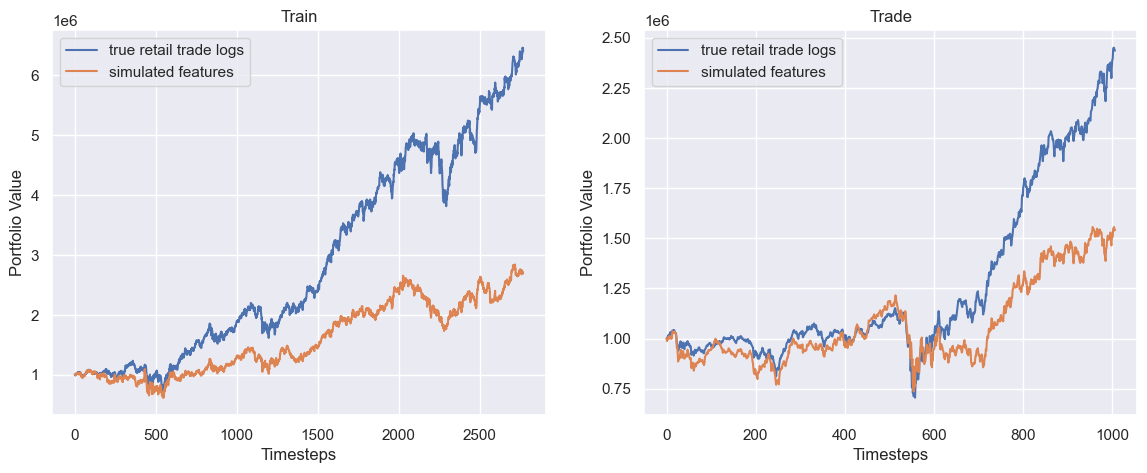

In [165]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(true_portfolio_train, label='true retail trade logs')
axs[0].plot(fake_ann_portfolio_train, label='simulated features')
axs[0].set_ylabel('Portfolio Value')
axs[0].set_xlabel('Timesteps')
axs[0].set_title('Train')
axs[0].legend()

axs[1].plot(true_portfolio_trade, label='true retail trade logs')
axs[1].plot(fake_ann_portfolio_trade, label='simulated features')
axs[1].set_ylabel('Portfolio Value')
axs[1].set_xlabel('Timesteps')
axs[1].set_title('Trade')
axs[1].legend()

In [166]:
backtest_helper(true_portfolio_train, train_data)

Annual return          0.184
Cumulative returns     5.403
Annual volatility      0.249
Sharpe ratio           0.803
Calmar ratio           0.447
Stability              0.960
Max drawdown          -0.411
Omega ratio            1.161
Sortino ratio          1.185
Skew                     NaN
Kurtosis                 NaN
Tail ratio             0.985
Daily value at risk   -0.031
dtype: float64


In [167]:
backtest_helper(reg_portfolio_train, train_data)

Annual return          0.099
Cumulative returns     1.835
Annual volatility      0.246
Sharpe ratio           0.509
Calmar ratio           0.196
Stability              0.885
Max drawdown          -0.509
Omega ratio            1.100
Sortino ratio          0.732
Skew                     NaN
Kurtosis                 NaN
Tail ratio             0.965
Daily value at risk   -0.030
dtype: float64


In [168]:
backtest_helper(clf_portfolio_train, train_data)

Annual return          0.099
Cumulative returns     1.832
Annual volatility      0.246
Sharpe ratio           0.508
Calmar ratio           0.195
Stability              0.885
Max drawdown          -0.509
Omega ratio            1.100
Sortino ratio          0.732
Skew                     NaN
Kurtosis                 NaN
Tail ratio             0.965
Daily value at risk   -0.031
dtype: float64


In [169]:
backtest_helper(lstm_portfolio_train, train_data)

Annual return          0.169
Cumulative returns     4.559
Annual volatility      0.249
Sharpe ratio           0.751
Calmar ratio           0.401
Stability              0.954
Max drawdown          -0.421
Omega ratio            1.151
Sortino ratio          1.106
Skew                     NaN
Kurtosis                 NaN
Tail ratio             0.986
Daily value at risk   -0.031
dtype: float64


In [170]:
backtest_helper(ann_portfolio_train, train_data)

Annual return          0.181
Cumulative returns     5.211
Annual volatility      0.249
Sharpe ratio           0.791
Calmar ratio           0.441
Stability              0.957
Max drawdown          -0.410
Omega ratio            1.159
Sortino ratio          1.168
Skew                     NaN
Kurtosis                 NaN
Tail ratio             1.000
Daily value at risk   -0.031
dtype: float64


In [171]:
backtest_helper(true_portfolio_trade, trade_data)

Annual return          0.249
Cumulative returns     1.436
Annual volatility      0.254
Sharpe ratio           1.006
Calmar ratio           0.643
Stability              0.699
Max drawdown          -0.388
Omega ratio            1.214
Sortino ratio          1.454
Skew                     NaN
Kurtosis                 NaN
Tail ratio             1.052
Daily value at risk   -0.031
dtype: float64


In [172]:
backtest_helper(reg_portfolio_trade, trade_data)

Annual return          0.158
Cumulative returns     0.798
Annual volatility      0.253
Sharpe ratio           0.708
Calmar ratio           0.390
Stability              0.574
Max drawdown          -0.404
Omega ratio            1.148
Sortino ratio          1.004
Skew                     NaN
Kurtosis                 NaN
Tail ratio             0.978
Daily value at risk   -0.031
dtype: float64


In [173]:
backtest_helper(clf_portfolio_trade, trade_data)

Annual return          0.158
Cumulative returns     0.797
Annual volatility      0.253
Sharpe ratio           0.707
Calmar ratio           0.390
Stability              0.574
Max drawdown          -0.405
Omega ratio            1.148
Sortino ratio          1.004
Skew                     NaN
Kurtosis                 NaN
Tail ratio             0.978
Daily value at risk   -0.031
dtype: float64


In [174]:
backtest_helper(lstm_portfolio_trade, trade_data)

Annual return          0.219
Cumulative returns     1.210
Annual volatility      0.287
Sharpe ratio           0.837
Calmar ratio           0.492
Stability              0.787
Max drawdown          -0.445
Omega ratio            1.187
Sortino ratio          1.190
Skew                     NaN
Kurtosis                 NaN
Tail ratio             1.127
Daily value at risk   -0.035
dtype: float64


In [177]:
backtest_helper(ann_portfolio_trade, trade_data)

Annual return          0.286
Cumulative returns     1.737
Annual volatility      0.254
Sharpe ratio           1.118
Calmar ratio           0.991
Stability              0.768
Max drawdown          -0.289
Omega ratio            1.221
Sortino ratio          1.727
Skew                     NaN
Kurtosis                 NaN
Tail ratio             1.039
Daily value at risk   -0.031
dtype: float64
